In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import coint

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.svm import SVC
from sklearn.model_selection import KFold

from numpy.random import normal, uniform

from sympy import symbols, diff, log, exp, sqrt

In [23]:
# helper functions for chapter

def sharpe(sl, pt, p, n_bets):
    # n_bets is the number of bets per year
    
    num = (pt - sl)*p + sl
    denom = (pt - sl)*np.sqrt(p*(1-p))
    return num/denom * np.sqrt(n_bets)

def implied_precision(SR, sl, pt, n_bets):
    # n_bets is the number of bets per year, SR is annualized
    
    a = (n_bets + SR**2)*(pt - sl)**2
    b = (2*n_bets*sl - SR**2*(pt - sl))*(pt - sl)
    c = n_bets*sl**2
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

def implied_n_bets(SR, sl, pt, p):
    # n_bets is the number of bets per year, SR is annualized
    
    num = (1-p)*p*(pt - sl)**2*SR**2
    denom = (p*(pt - sl) + sl)**2
    return num/denom
    
def implied_pt(SR, sl, p, n):
    # n is the number of bets per year, SR is annualized
    
    num = sl*(np.sqrt(n)*(p-1) - np.sqrt(p*(1 - p))*SR)
    denom = np.sqrt(n)*p - np.sqrt(p*(1-p))*SR
    return num/denom

def implied_sl(SR, pt, p, n):
    # n is the number of bets per year, SR is annualized
    
    num = np.sqrt(n)*p*pt - np.sqrt((1 - p)*p)*pt*SR
    denom = np.sqrt(n)*(p-1) - np.sqrt((1 - p)*p)*SR
    return num/denom

def compute_PSR(benchmark, SR_observed, observations, skew, kurtosis):
    num = (SR_observed - benchmark) * np.sqrt(observations - 1)
    denom = np.sqrt(1 - skew * SR_observed + (kurtosis - 1)*SR_observed**2/4)
    
    return norm.cdf(num/denom)

def prob_strategy_failure(m_1, m_2, s_1, s_2, p_1, n_samples, benchmark):

    g1 = normal(loc=m_1, scale=s_1, size=int(p_1*n_samples))
    g2 = normal(loc=m_2, scale=s_2, size=n_samples - int(p_1*n_samples))
    
    samples = np.concat([g1, g2])
    
    rPos, rNeg = samples[samples>0].mean(),samples[samples<=0].mean()
    
    p = samples[samples>0].shape[0]/float(samples.shape[0])

    thresP = implied_precision(SR=benchmark, sl=rNeg, pt=rPos, n_bets=12)
    
    risk = norm.cdf(thresP, p, p*(1-p))

    return risk

# Exercises

### 15.1

A portfolio manager intends to launch a strategy that targets an annualized SR of
2. Bets have a precision rate of 60%, with weekly frequency. The exit conditions
are 2% for profit-taking, and –2% for stop-loss.

(a) Is this strategy viable?

(b) Ceteris paribus, what is the required precision rate that would make the
strategy profitable?

(c) For what betting frequency is the target achievable?

(d) For what profit-taking threshold is the target achievable?

(e) What would be an alternative stop-loss?

In [10]:
# The strategy is not viable, it only yields an annualized sharpe ratio of 1.47
print("Sharpe Ratio: ", sharpe(-0.02, 0.02, 0.6, 52) )

# The required precision is ~0.634
print("Implied Precision: ", implied_precision(2, -0.02, 0.02, 52))

# The required betting frequency is 96 bets per year
print("Implied Bets per Year: ", implied_n_bets(2, -0.02, 0.02, 0.6))

# the required profit taking threshold is ~0.023
print("Implied Profit Taking: ", implied_pt(2, -0.02, 0.6, 52))

# the required stop loss threshold is ~-0.017
print("Implied Stop Loss: ", implied_sl(2, 0.02, 0.6, 52))

Sharpe Ratio:  1.4719601443879746
Implied Precision:  0.6336306209562126
Implied Bets per Year:  96.0
Implied Profit Taking:  0.023091676456151216
Implied Stop Loss:  -0.01732225898624381


### 15.2 

Following up on the strategy from exercise 1.

(a) What is the sensitivity of SR to a 1% change in each parameter?

(b) Given these sensitivities, and assuming that all parameters are equally hard
to improve, which one offers the lowest hanging fruit?

(c) Does changing any of the parameters in exercise 1 impact the others? For
example, does changing the betting frequency modify the precision rate,
etc.?

(0.0, 3.0)

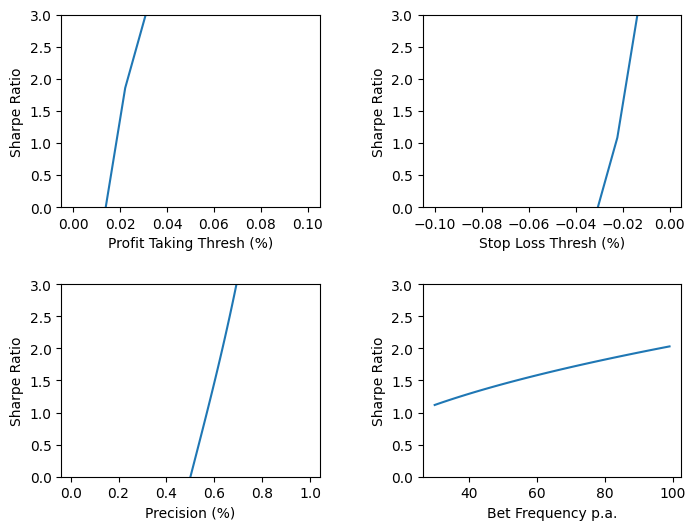

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

plt.subplots_adjust(wspace=0.4, hspace=0.4)

pt_grid = np.linspace(0, 0.1, 10)
SR_pt_grid = sharpe(-0.02, pt_grid, 0.6, 52)
ax[0, 0].plot(pt_grid, SR_pt_grid)
ax[0, 0].set_ylabel("Sharpe Ratio")
ax[0, 0].set_xlabel("Profit Taking Thresh (%)")
ax[0, 0].set_ylim(0, 3)


sl_grid = np.linspace(0, -0.1, 10)
SR_sl_grid = sharpe(sl_grid, 0.02, 0.6, 52)
ax[0, 1].plot(sl_grid, SR_sl_grid)
ax[0, 1].set_ylabel("Sharpe Ratio")
ax[0, 1].set_xlabel("Stop Loss Thresh (%)")
ax[0, 1].set_ylim(0, 3)

p_grid = np.linspace(0.01, 0.99, 100)
SR_p_grid = sharpe(-0.02, 0.02, p_grid, 52)
ax[1, 0].plot(p_grid, SR_p_grid)
ax[1, 0].set_ylabel("Sharpe Ratio")
ax[1, 0].set_xlabel("Precision (%)")
ax[1, 0].set_ylim(0, 3)

n_bets = np.arange(30, 100)
SR_bets_grid = sharpe(-0.02, 0.02, 0.6, n_bets)
ax[1, 1].plot(n_bets, SR_bets_grid)
ax[1, 1].set_ylabel("Sharpe Ratio")
ax[1, 1].set_xlabel("Bet Frequency p.a.")
ax[1, 1].set_ylim(0, 3)

In [14]:
# Bump each parameter by 0.01 and compute sensitivities
bump = 0.01
sl_sensitivity = sharpe(-0.02*(1 - bump), 0.02, 0.6, 52) - sharpe(-0.02, 0.02, 0.6, 52)
pt_sensitivity = sharpe(-0.02, 0.02*(1 + bump), 0.6, 52) - sharpe(-0.02, 0.02, 0.6, 52)
p_sensitivity = sharpe(-0.02, 0.02, 0.6*(1 + bump), 52) - sharpe(-0.02, 0.02, 0.6, 52)
n_sensitivity = sharpe(-0.02, 0.02, 0.6, 52*(1 + bump)) - sharpe(-0.02, 0.02, 0.6, 52)

data = [sl_sensitivity, pt_sensitivity, p_sensitivity, n_sensitivity]
data = [np.round(x, 2) for x in data]

labels = ["Stop Loss", "Profit Taking", "Precision", "Bet Frequency p.a."]

pd.DataFrame(index=labels, data=data, columns=["Sensitivity of Sharpe Ratio"])

,Sensitivity of Sharpe Ratio
Stop Loss,0.04
Profit Taking,0.04
Precision,0.09
Bet Frequency p.a.,0.01


The Sharpe ratio has the highest sensitivity to the precision. However, sensitivity to stop loss and profit taking is non-negligable, so one could consider tuning these parameters as well.  There is not much to be gained by changing the number of bets, unless it can be changed a lot.

Text(0.5, 1.0, 'Implied Precision for Fixed Sharpe vs. Bet Frequency')

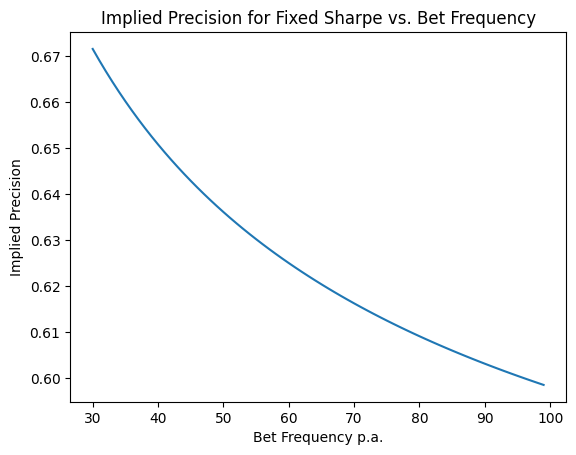

In [15]:
# Now investigate cross effects
bet_grid = np.arange(30, 100)
p_bet_grid = implied_precision(2, -0.02, 0.02, bet_grid)

plt.plot(bet_grid, p_bet_grid)
plt.ylabel("Implied Precision")
plt.xlabel("Bet Frequency p.a.")
plt.title("Implied Precision for Fixed Sharpe vs. Bet Frequency")

Yes, there are cross effects; maximizing Sharpe is a multiple-dimensional optimization problem. For example, raising the betting frequency lowers the implied precision, i.e. the precision required to attain a particular sharpe

### 15.3

Suppose a strategy that generates monthly bets over two years, with returns
following a mixture of two Gaussian distributions. The first distribution has
a mean of –0.1 and a standard deviation of 0.12. The second distribution has
a mean of 0.06 and a standard deviation of 0.03. The probability that a draw
comes from the first distribution is 0.15.

(a) Following Lopez de Prado and Peijan [2004] and L ´ opez de Prado and Fore- ´
man [2014], derive the first four moments for the mixture’s returns.

(b) What is the annualized SR?

(c) Using those moments, compute PSR[1] (see Chapter 14). At a 95% confidence level, would you discard this strategy?

It is straightforward to show that the cumulant generating function for a mixture of $N$ gaussians is given by (note that the kurtosis is 0 for a gaussian)
$$ G(t) = \log\Big(\sum_{i=1}^{N} \exp(t \mu_i + \frac{t^2\sigma_i^2}{2}) p(g_i) \Big)$$

For this strategy, we assume that a bet is made every month, and the following returns reflect the performance over that month. Given their values, this seems reasonable

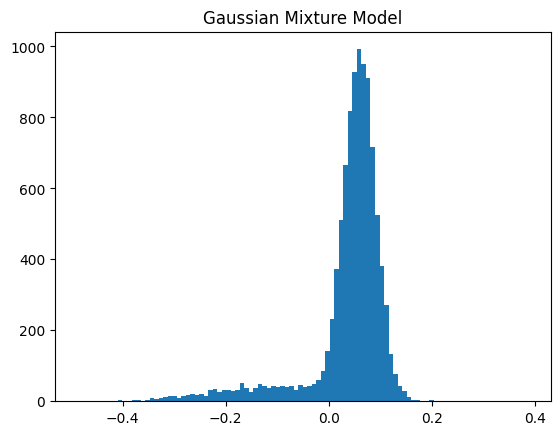

In [16]:
# Plot histogram of model distribution
from numpy.random import normal, uniform

n_samples = 10_000
m_1 = -0.1, 
m_2 = 0.06
s_1 = 0.12
s_2 = 0.03
p_1 = 0.15

g1 = normal(loc=m_1, scale=s_1, size=int(p_1*n_samples))
g2 = normal(loc=m_2, scale=s_2, size=n_samples - int(p_1*n_samples))

samples = np.concat([g1, g2])

plt.hist(samples, bins=100);
plt.title("Gaussian Mixture Model");

In [20]:
m1, m2, s1, s2, t, p1 = symbols('m1 m2 s1 s2 t p1')
subs = {"t":0, "m1":-0.1, "s1":0.12, "m2":0.06, "s2":0.03, "p1":0.15}

G = log(p1 * exp(t * m1 + (t**2 * s1**2) / 2) + (1 - p1)*exp(t*m2 + (t**2 * s2**2)/2))

sharpe_benchmark = 0

mean = float(diff(G, t).evalf(subs=subs))
std = np.sqrt(float(diff(diff(G, t), t).evalf(subs=subs)))
skew = float(diff(diff(diff(G, t), t), t).evalf(subs=subs))
kurtosis = float(diff(diff(diff(diff(G, t), t), t), t).evalf(subs=subs) + 3)

annualized_sharpe = np.sqrt(12)*mean/std

PSR = compute_PSR(benchmark = sharpe_benchmark, 
                  SR_observed = mean/std, # use sharp on same time scale as observations 
                  observations = 12*2, # this is total observations, not obs per year
                  skew = skew, 
                  kurtosis = kurtosis)

data = [mean, std, skew, kurtosis, annualized_sharpe, np.sqrt(12)*sharpe_benchmark, PSR]
labels = ["mean", "standard deviation", "skew", "kurtosis", "Sharpe", "Sharpe Benchmark", "PSR"]

pd.DataFrame(columns=labels, data=[data])

,mean,standard deviation,skew,kurtosis,Sharpe,Sharpe Benchmark,PSR
0,0.036,0.07867,-0.001192,3.000274,1.585196,0.0,0.981578


Based on the PSR, The strategy should not be rejected, especially against a benchmark of zero. This intuitively makes sense; the strategy almost always draws from the positively positioned gaussian, and when it does, its return is consistently around the mean 

### 15.4 - 15.5

Using Snippet 15.5, compute P[p < p𝜃∗=1] for the strategy described in exercise
3. At a significance level of 0.05, would you discard this strategy? Is this result
consistent with PSR[𝜃∗]?

In general, what result do you expect to be more accurate, PSR[𝜃∗] or
P[p < p𝜃∗=1]? How are these two methods complementary?

In [28]:
# compute probability of strategy failure
prob_failure = prob_strategy_failure(m_1, m_2, s_1, s_2, p_1, 100_000, 0)

In [29]:
data = [mean, std, skew, kurtosis, annualized_sharpe, np.sqrt(12)*sharpe_benchmark, PSR, prob_failure]
labels = ["mean", "standard deviation", "skew", "kurtosis", "Sharpe", "Sharpe Benchmark", "PSR", "Prob Fail"]

pd.DataFrame(columns=labels, data=[data])

,mean,standard deviation,skew,kurtosis,Sharpe,Sharpe Benchmark,PSR,Prob Fail
0,0.036,0.07867,-0.001192,3.000274,1.585196,0.0,0.981578,0.051457


There is a low but not insignificant chance that the strategy fails.  This does not contradict the fact that the true sharp ratio is greater than the benchmark 0, which we concluded from the PSR test. The probability of failure is also sensitive to the variance of the measured sharpe ratio, which can be large.